In [ ]:
import numpy as np
import pandas as pd

import scipy

import matplotlib.pyplot as plt

import os

#-----------------------------------

import torch.nn as nn

#------------------------------------

import poseigen_seaside.basics as se

import poseigen_trident.utils as tu
import poseigen_trident.preass as pa

import poseigen_binmeths as bm

In [3]:
data_path = "../data/R9/"
os.makedirs(data_path, exist_ok=True)

os.chdir(data_path)

os.getcwd()

'/mnt/x/Computation/Polished/case_studies/DevLoss/data/R9'

# Data Prep

In [4]:
inp_num = 10

snx_shared = {'dim_i': (inp_num, 1, 1),
              'P1_mods': 4, 'P1_cf_ns': 0, 
              'P1_cf_i': inp_num, 'P1_cf_pu': inp_num, 
              'batchnorm': 'before', 'activations': nn.ReLU()}

snx1 = {'dim_f': (2, 1, 1), **snx_shared}
snx2 = {'dim_f': (1, 1, 1), **snx_shared}

se.PickleDump([snx1, snx2], 'snxs')

In [5]:
pa.SimpNet(**snx1)

SimpNet(
  (P1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  )
)

In [6]:
pa.SimpNet(**snx2)

SimpNet(
  (P1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  )
)

## Initial Generation

In [ ]:
# obsx = 1000000

# synth_generated = {}

# for igenr in np.arange(20):

#     SimpNetX1 = pa.SimpNet(**snx1)
#     #torch.save(SimpNetX1, datafolder + 'SimpNetX1_' + str(synth_counter) + '.pt')

#     synth_X = np.random.uniform(-1, 1, size = (obsx, *(inp_num, 1, 1)))

#     synth_Y = tu.TridentPredictor(SimpNetX1, synth_X, batchsize = 512)

#     synth_generated[igenr] = {'synth_X': synth_X, 'synth_Y': synth_Y}

#     #print(igenr)

# se.PickleDump(synth_generated, 'synth_generated')

In [ ]:
# for igner in np.arange(20): 
#     print(igner)
#     plt.figure()
#     f, axarr = plt.subplots(1, 2)
#     axarr[0].hist(synth_generated[igner]['synth_Y'][:, 0].reshape(-1), bins = 50);
#     axarr[1].hist(synth_generated[igner]['synth_Y'][:, 1].reshape(-1), bins = 50);
#     # Show/save figure as desired.
#     plt.show()

In [ ]:
# synth_generated_passedidx = [0, 2, 3, 4, 5, 6, 8, 14, 18, 19]

# synth_generated_filt = {ix: synth_generated[x] for ix, x in enumerate(synth_generated_passedidx)}

# se.PickleDump(synth_generated_filt, 'synth_generated_filt')

In [ ]:
synth_generated_filt = se.PickleLoad('synth_generated_filt')

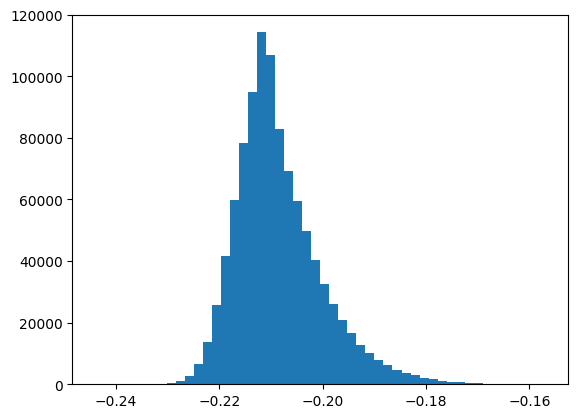

In [15]:
plt.hist(synth_generated_filt[1]['synth_Y'][:, 1].reshape(-1), bins = 50);

## Synth Data - adding noise and selection

In [9]:
num_synth_rep = 10
num_dataproc_rep = 5
num_split_rep = 5

In [10]:
synth_generated_filt = se.PickleLoad('synth_generated_filt')

In [ ]:
noise_lvls = [0, 0.5, 1.0]
noise_labels = ["None", "Low", "High"]

cent = 0
plusminus = 1
my_std = 0.5

myclip_a = cent-plusminus
myclip_b = cent+plusminus
my_mean = (myclip_a + myclip_b) / 2
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

#------------------------------------------------------------

num_obs = [20000, 10000, 5000]

replics = 3

tre_m, con_m = 200, 10

tlim = 1 #number of standard deviations to cut in initial. 

#------------------------------------------------------------
binx = 10
fin_bins = 10

In [ ]:
synth_data = {}

for syr in np.arange(num_synth_rep):
    synth_data[syr] = {}
    synth_X, synth_Y = [synth_generated_filt[syr][x] for x in ['synth_X', 'synth_Y']]
    lsy = len(synth_Y)


    for dpr in np.arange(num_dataproc_rep):

        synth_data[syr][dpr] = {}

        for inobs, nobs in enumerate(num_obs):
            
            synth_data[syr][dpr][inobs] = {}
            
            for inx, (nx, nlabel) in enumerate(zip(noise_lvls, noise_labels)):

                cutoz = []
                for g in [0, 1]:
                    targ = synth_Y[:, g].reshape(-1)
                    targ_mean, targ_std = np.mean(targ), np.std(targ)
                    targ_std_lim = tlim * targ_std
                    cuto = (targ > (targ_mean - targ_std_lim)) * (targ < (targ_mean + targ_std_lim))
                    cutoz.append(cuto)
                cutA = cutoz[0] * cutoz[1]
                synth_X_selA, synth_Y_selA = [x[cutA] for x in [synth_X, synth_Y]]
                cut1_num = 10000 * 20

                if len(synth_Y_selA) > cut1_num:
                    print(f'{nlabel}: passed check 1')
                else:
                    print(f'{nlabel}: failed check 1')
                    continue
                    
                
                Y_selA_bin = np.array([bm.HistBinning(synth_Y_selA[:, g].reshape(-1), bins=binx) for g in [0, 1]]).T
                Y_selA_bin_comb = bm.BinsOfBins(Y_selA_bin, uni=[np.arange(binx), np.arange(binx)])
                cutB_idx = bm.Harpoon(Y_selA_bin_comb, nobs)
                print(bm.BinCount(Y_selA_bin_comb[cutB_idx]))
                synth_X_selB, synth_Y_selB = [x[cutB_idx] for x in [synth_X_selA, synth_Y_selA]]
                

                epsilon = 1e-8
                selB_min, selB_max = np.min(synth_Y_selB, axis = 0, keepdims=True), np.max(synth_Y_selB, axis = 0, keepdims=True)
                synth_Y_selB_mmnorm = ((synth_Y_selB - selB_min) / (selB_max - selB_min))

                synth_Y_selB_scale = (synth_Y_selB_mmnorm * np.array([tre_m, con_m]).reshape(1, -1, 1, 1)) + 5

                
            
                noio = scipy.stats.truncnorm.rvs(a, b, loc=my_mean, scale=my_std, size=(len(synth_Y_selB_mmnorm), 2, 1, 1))

                synth_Y_noise = synth_Y_selB_scale.copy() if nlabel == "None" else synth_Y_selB_scale * np.exp(noio * nx)
                    
                    
                synth_Y_real_exp = synth_Y_noise

                synth_Y_real_mod = tu.BetaPrime_Mode(*[synth_Y_real_exp[:, g].reshape(-1) 
                                                    for g in [0, 1]])
                
                synth_Y_reps = np.array([[scipy.stats.gamma.rvs(tar, size=replics) 
                                        for tar in synth_Y_real_exp[:, g].reshape(-1)] 
                                        for g in [0, 1]])
                
                synth_Y_reps_exp = np.mean(synth_Y_reps, axis=-1).T

                synth_Y_reps_mod = tu.BetaPrime_Mode(*[synth_Y_reps_exp[:, g] 
                                                    for g in [0, 1]])

                obs_bind = bm.HistBinning(synth_Y_reps_mod.reshape(-1), bins=fin_bins)
                print(bm.BinCount(obs_bind, uni=np.arange(fin_bins), multi=False))

                synth_Y_reps_mod, synth_Y_real_mod = [x.reshape(-1, 1, 1, 1) for x in [synth_Y_reps_mod, synth_Y_real_mod]]
                synth_Y_reps_exp, synth_Y_real_exp = [x.reshape(-1).reshape(-1, 1, 1, 1, 2) for x in [synth_Y_reps_exp, synth_Y_real_exp]]
                obs_bind = obs_bind.reshape(-1, 1, 1, 1)

                synth_data[syr][dpr][inobs][nlabel] = {
                    
                    'd_x': synth_X_selB,

                    'd_mode': synth_Y_reps_mod,
                    'd_exp': synth_Y_reps_exp,
                    'd_b': obs_bind,

                    'before_noise': synth_Y_selB_scale, 

                    'after_noise_exp': synth_Y_noise,
                    'after_noise_mode': synth_Y_real_mod,
                }

                #if nx == 0.25: break

    print(f'Finished: {syr}')

se.PickleDump(synth_data, 'synth_data')

None: passed check 1
[205 206 206 205 206 205 205 124  46  21 206 206 205 205 206 206 205 205
 205  90 206 206 205 205 206 205 205 205 205 206 205 205 205 205 206 205
 205 205 206 205 206 205 205 205 206 205 206 205 206 206 205 205 206 205
 206 205 205 205 205 206 205 206 205 206 205 205 205 205 205 205 206 205
 206 205 205 205 206 206 205 206 206 205 206 205 205 205 206 206 206 206
 205 205 206 205 205 206 206 206 206 205]
[5919 6675 4480 1894  688  250   69   19    4    2]
Low: passed check 1
[205 206 205 206 205 206 205 124  46  21 206 205 205 205 205 205 205 205
 206  90 206 205 206 205 205 205 206 205 206 205 205 206 206 205 205 206
 205 206 205 206 206 206 206 206 205 205 205 206 206 206 205 206 205 205
 205 205 205 205 205 205 206 206 205 205 206 205 206 205 205 205 206 206
 205 205 206 206 206 206 205 205 205 205 206 205 205 205 206 206 206 206
 205 205 206 205 205 205 206 205 205 205]
[8945 6969 2754  885  287  106   30   18    4    2]
High: passed check 1
[206 205 205 206 205

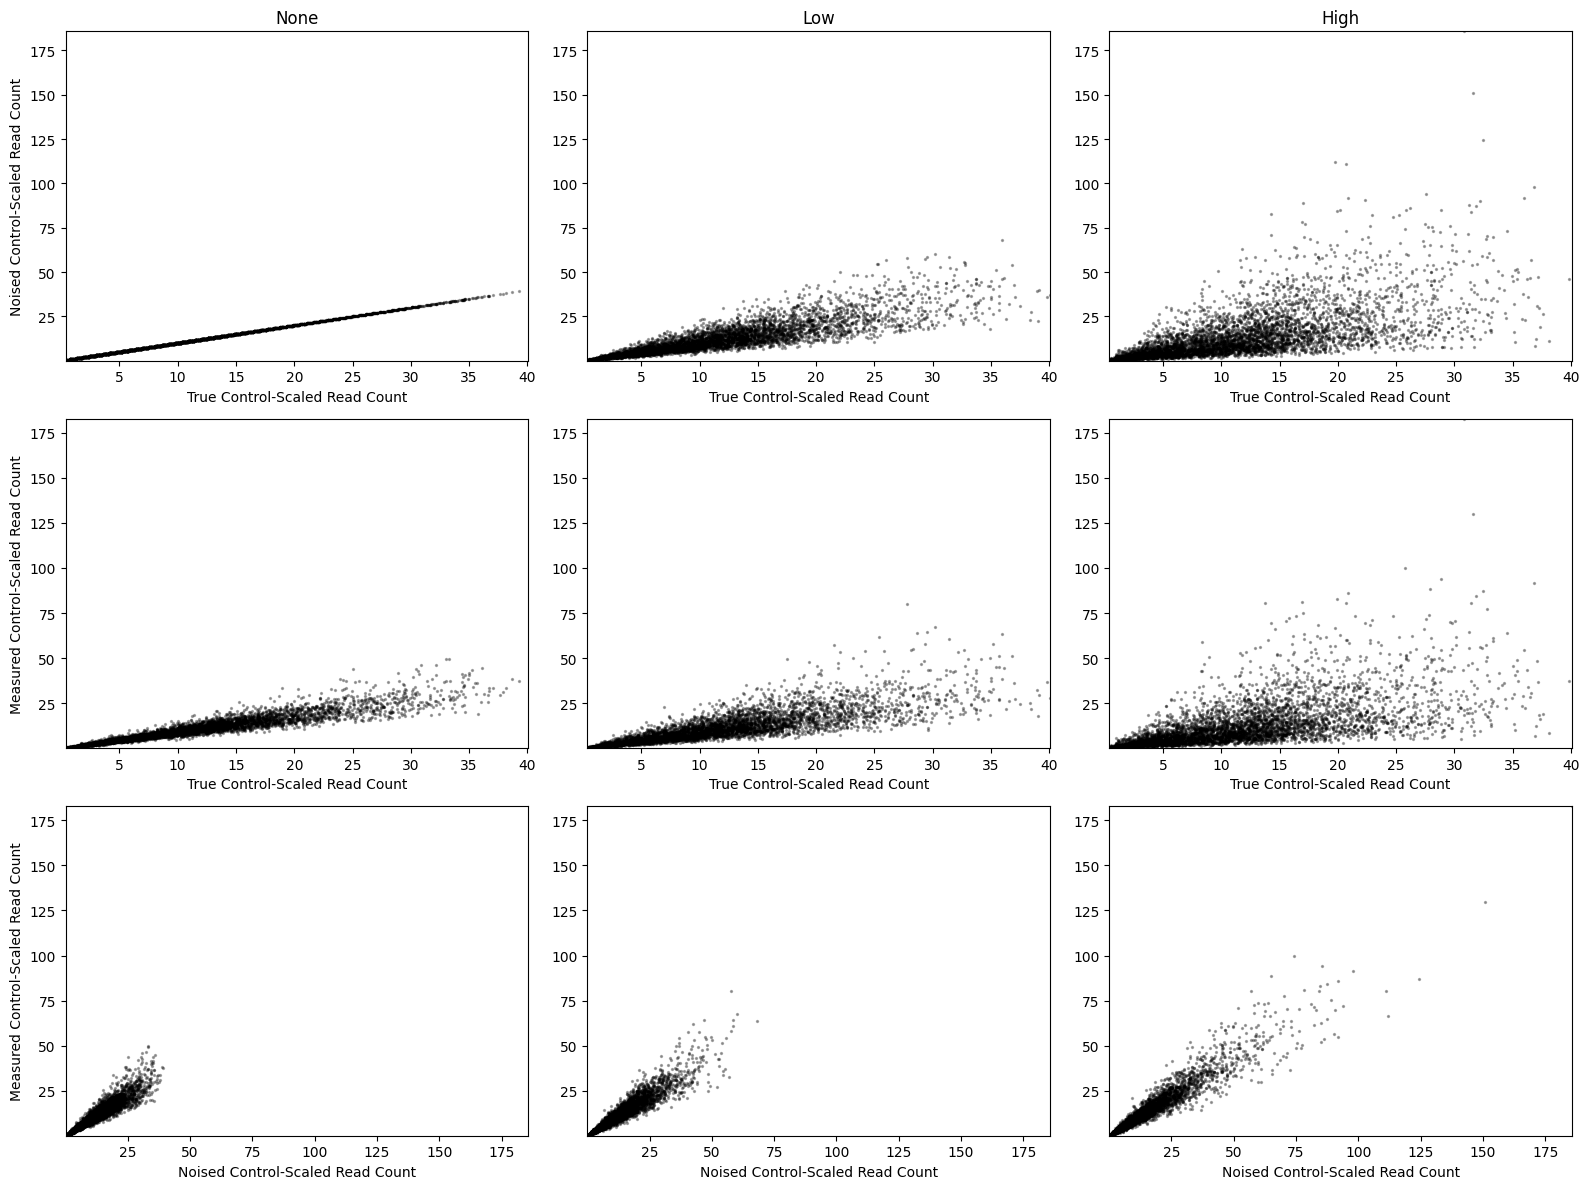

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# synth_data = se.PickleLoad(datafolder + 'synth_data')

synth_rep = 0
dataproc_rep = 0
inobs = 2

epsilon = 1e-8

fig, axes = plt.subplots(3, len(noise_labels), figsize=(16, 12))

# Store x and y values for each row to compute min/max
xvals = [[], [], []]
yvals = [[], [], []]

for i, nkey in enumerate(noise_labels):
    d = synth_data[synth_rep][dataproc_rep][inobs][nkey]
    before_noise = d['before_noise']
    after_noise = d['after_noise_exp']
    d_mode = d['d_mode']

    real_ratio = before_noise[:, 0] / (before_noise[:, 1] + epsilon)
    noised_ratio = after_noise[:, 0] / (after_noise[:, 1] + epsilon)
    d_mode_flat = d_mode.reshape(-1)

    # Top row: real_ratio vs noised_ratio
    axes[0, i].scatter(real_ratio.reshape(-1), noised_ratio.reshape(-1), s=2, alpha=0.3, color='black')
    axes[0, i].set_title(nkey)
    axes[0, i].set_xlabel('True Control-Scaled Read Count')
    if i == 0:
        axes[0, i].set_ylabel('Noised Control-Scaled Read Count')
    xvals[0].append(real_ratio.reshape(-1))
    yvals[0].append(noised_ratio.reshape(-1))

    # Middle row: real_ratio vs d_mode
    axes[1, i].scatter(real_ratio.reshape(-1), d_mode_flat, s=2, alpha=0.3, color='black')
    axes[1, i].set_xlabel('True Control-Scaled Read Count')
    if i == 0:
        axes[1, i].set_ylabel('Measured Control-Scaled Read Count')
    xvals[1].append(real_ratio.reshape(-1))
    yvals[1].append(d_mode_flat)

    # Bottom row: noised_ratio vs d_mode
    axes[2, i].scatter(noised_ratio.reshape(-1), d_mode_flat, s=2, alpha=0.3, color='black')
    axes[2, i].set_xlabel('Noised Control-Scaled Read Count')
    if i == 0:
        axes[2, i].set_ylabel('Measured Control-Scaled Read Count')
    xvals[2].append(noised_ratio.reshape(-1))
    yvals[2].append(d_mode_flat)

# Set x and y limits for each row based on all 4 plots in that row
for row in range(3):
    all_x = np.concatenate(xvals[row])
    all_y = np.concatenate(yvals[row])
    xmin, xmax = np.min(all_x), np.max(all_x)
    ymin, ymax = np.min(all_y), np.max(all_y)
    for i in range(len(noise_labels)):
        axes[row, i].set_xlim(xmin, xmax)
        axes[row, i].set_ylim(ymin, ymax)
    # Share x and y axes within the row
    for i in range(1, len(noise_labels)):
        axes[row, i].sharex(axes[row, 0])
        axes[row, i].sharey(axes[row, 0])

plt.tight_layout()
plt.show()

In [ ]:
# ##### Now need to do the splits: 

synth_data = se.PickleLoad('synth_data')

props = [0.6, 0.2, 0.2]

synth_splits = {syr: 
                {dpr: 
                 {inobs: 
                  {nlabel: 
                   {ispl: 
                    bm.SimpleStratifiedSplit(synth_data[syr][dpr][inobs][nlabel]['d_b'], props, prints=True)
                    
                    for ispl in np.arange(num_split_rep)}
                    for nlabel in noise_labels}
                    for inobs, nobs in enumerate(num_obs)} 
                    for dpr in np.arange(num_dataproc_rep)}
                    for syr in np.arange(num_synth_rep)}

se.PickleDump(synth_splits, 'synth_splits')

[array([3598, 3954, 2690, 1131,  419,  153,   42,   12,    3,    2]), array([1170, 1346,  889,  366,  117,   48,   16,    5,    0,    0]), array([1151, 1375,  901,  397,  152,   49,   11,    2,    1,    0])]
[array([3548, 4024, 2682, 1159,  419,  153,   41,   12,    3,    2]), array([1193, 1351,  891,  370,  146,   50,   15,    6,    1,    0]), array([1178, 1300,  907,  365,  123,   47,   13,    1,    0,    0])]
[array([3600, 3974, 2737, 1128,  403,  146,   40,   14,    3,    1]), array([1145, 1330,  904,  384,  135,   42,   12,    2,    1,    1]), array([1174, 1371,  839,  382,  150,   62,   17,    3,    0,    0])]
[array([3581, 4058, 2759, 1136,  411,  144,   43,   12,    4,    2]), array([1197, 1322,  840,  386,  132,   62,   12,    4,    0,    0]), array([1141, 1295,  881,  372,  145,   44,   14,    3,    0,    0])]
[array([3507, 4071, 2726, 1166,  377,  146,   45,   14,    4,    2]), array([1213, 1268,  881,  387,  162,   47,   10,    3,    0,    0]), array([1199, 1336,  873,  341